## Julia Rushton and Jocelyn Rupp

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import average 
from tensorflow.keras.models import  Model

2024-04-21 18:14:37.481704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Preparation (3 points total)  

### Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

The image dataset chosen for this lab is called "5 Flower Types Classification Dataset" from Kaggle (https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset). This dataset includes 5 different flower classes: Lilly, Louts, Sunflower, Orchid, and Tulip and there are 1000 images for each of the 5 types of flowers. This directory called flower_images has 5 flower sub-directories for each of the 5 flower types and within each subdirectory is 1000 jpeg files of images of that flower. The purpose of the dataset is to have "multi-class CNN be performed on this dataset to classify the flower belonging" to one of the 5 flower classes. The prediction task for this dataset is to classify images of flowers into one of five class: Lilly, Lotus, Sunflower, Orchid or Tulip. The goal of the classification problem is to predict the correct class label for each flower. The results of this flower classification task can have applications in various fields including botnay, education, retail, and conversation, making it releveant and potentially valuable to a diverse range of stakeholder. Specific potential third parties that might be interested include, botanical researchers, flower enthusiasts and hobbyists, and florist and flower shops. This data is important because it supports a wide range of scientific, educational, commercial, and technological applications, contributing to our knowledge of plant biology and enhancing various aspects of human life and society. For example, the botanical reasearch and education industry can benefit from this data because it can allow them to develop and validate machine learning models for automated flower classification, whcih can aid in plant identification, taxonomy and ecological research. Another example of a third party that would be interested in this data and find it important is species conservationists. This data can contribute to their efforts to monitor and conserve flower species. In order to be considered helpful to these third parties, our prediciton algorithm needs to have: high accuracy in classifying flower images into the correct classes, high precision to minimize false positives and negatives, great robustness and gernaralization across different datasets (such as the training and the new testing data), and finally high efficiency. These characteristics will make sure that the algorithm is relizable and useful for the third parties mentioned.

Although accuracy is rarely the best evualtion metric, we belive that since our classes are highly balanced, and in our case,each class has 1000 images, which suggests a balanced dataset. Accuracy can be a good metric when the class distribution is balanced since no class is underrepresented or overrepresented. When considering whats at stake in misclassifying an image, it is not of high priority for a flower to be misclassified. Since the cost of misclassification is the same across classes, then we believe accuracy is suffice.

### Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

Using an 80/20 split of data for training and testing in the context of training a Convolutional Neural Network (CNN) for image classification on our dataset is an appropriate method for several reasons:

The first is that there is sufficient training data. By using 80% of the data for training (i.e., 800 images per flower type), the CNN is provided with a substantial amount of examples to learn from. This is crucial because deep learning models, including CNNs, typically require large amounts of data to effectively learn the distinguishing features of different classes without overfitting. The volume of training data ensures that the model can generalize well across a diverse set of images within each flower category.
The second reason is that there is an adequate amount of validation data.  The remaining 20% of the data, which corresponds to 200 images per flower type, serves as the test or validation set. This subset is significant enough to validate the model's performance and check for overfitting. It's crucial that this data is separate and not used during training to ensure that the model's evaluation reflects its capability to generalize to new, unseen data. The third reason is that the data is balanced. Each class has an equal number of images and using the 80/20 spliy ensures that each class is equally represented in both phases. This would also prevent class imbalance which in turn woulf skew the learning and evaluation metrics.

Our method is a realistic mirroring of how an algorithm would be used in practice because it is a common practice in machine learning esepcially with tasks involving classification. This method balances the need for learning complex patterns in the data while retaining enough data to assess model performance. Overall, an 80/20 split in this context not only makes practical use of the data for training and validation purposes but also adheres to common practices in machine learning, providing a good balance between learning and validation capabilities for a CNN.

### Modeling (6 points total)

#### Reading in the data

In [2]:
from PIL import Image
import numpy as np
import os

# directory where flower dataset is located
base_dir = '/Users/juliarushton/Downloads/flower_images'
#base_dir = 'flower_images'

images = []
labels = []

acceptable_extensions = ['.jpg', '.jpeg']

# define a uniform size for all images (width, height) in pixels
uniform_size = (64, 64)  


for dir_name, _, file_names in os.walk(base_dir):
    # Get folder_name from the directory name
    new_label = os.path.basename(dir_name)
    
    for file_name in file_names:
        # Check if the file has an acceptable extension
        if any(file_name.lower().endswith(ext) for ext in acceptable_extensions):
            
            # Construct the full path to the image
            file_path = os.path.join(dir_name, file_name)
            
            try:
                # Open the image
                with Image.open(file_path) as img:
                    # Resize the image to the uniform size
                    img_resized = img.resize(uniform_size)
                    
                    # Convert image to a NumPy array
                    img_array = np.array(img_resized)
                    
                    # Append the linearized array to the list of image arrays
                    images.append(img_array)
                    
                    # Check if the new label already exists in the labels array
                    # if new_label not in labels:
                    # If it doesn't exist, append the new label
                    labels.append(new_label)
                    
            except IOError:
                # Handle the exception for files that cannot be opened.
                print(f"Cannot open {file_path}. Skipping.")

Not greyscaling the images produced better outputs. Color is necessary for identifying different flowers. 

In [3]:
print(list(set(labels)))

['Sunflower', 'Lotus', 'Orchid', 'Tulip', 'Lilly']


In [5]:
import pandas as pd

labels_ohe = pd.get_dummies(labels, dtype = int).values

labels_ohe

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [6]:
#justify 80/20 split with explanation large enough data 
#stratify with trai and test

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
images = np.array(images)
images_train, images_test, labels_train, labels_test = train_test_split(images, labels_ohe, test_size=0.2, random_state=42, stratify = labels)
labels_number_test = np.argmax(labels_test, axis = 1)

### Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You should make use of Keras augmentation layers, like in the class examples.

Our data expansion consist of a horizontal flip. We tested other augmentations like a vertical flip, and rotations, but found that it was not useful for our case. For classying flower image data, the only edge case that we found mattered the most was a horizontal flip of a flower.  Horizontal flipping effectively doubles the dataset's size and provides variations that help the CNN learn to recognize flowers from different perspectives, thus enhancing its ability to generalize from the training data to new, unseen images. For instance, a horizontally flipped image of a sunflower or tulip still maintains a natural orientation that could be encountered in real life. This kind of augmentation helps the model to learn invariant features of flowers regardless of their orientation on the horizontal axis. Vertical flipping  would cause an unnatural perspective and certain degrees of rotation might create images that do not commonly occur in nature. For example, most flowers grow upwards, and their typical viewing angles are from the side or looking down. A vertical flip could result in an image where the flower appears to be upside down, which is rare and thus might not only be unhelpful but could potentially confuse the model by introducing unrealistic examples. This model will be better equipped to handle variations in flower orientation that it might encounter in a typical usage scenario, thereby improving its accuracy. 

The same augementation is implemented in each of the four CNN's below via the "cnn#.add( RandomFlip("horizontal") )" line of code.



### The following tasks are done throughout this document

##### Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures and investigate changing one or more parameters of each architecture such as the number of filters. This means, at a  minimum, you will train a total of four models (2 different architectures, with 2 parameters changed in each architecture). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

#####  Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

### 2 with different parameters

In [7]:
%%time 

cnn1 = Sequential()

# add in augmentations directly
cnn1.add( RandomFlip("horizontal") )
# cnn1.add( RandomRotation(0.1) )

# let's start with an AlexNet style convolutional phase
cnn1.add(Conv2D(filters=32,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn1.add(Conv2D(filters=32,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn1.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn1.add(Flatten())
cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn1.add(Dense(len(set(labels)), activation='softmax'))

# Let's train the model 
cnn1.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])
## potentially play with keras object 
cnn1.build((None,64,64,3))

cnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,205,221 (16.04 MB)

 Trainable params: 4,205,221 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 176 ms, sys: 39.1 ms, total: 215 ms
Wall time: 222 ms


In [8]:
# saving each loss function at each epoch
history1 = cnn1.fit(
    images_train, labels_train, epochs = 10, validation_data = (images_test, labels_test)
)
#ruun with ten on augmentatiin, then see with epochs

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 210ms/step - accuracy: 0.3025 - loss: 130.2176 - val_accuracy: 0.3690 - val_loss: 1.6154
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 208ms/step - accuracy: 0.4040 - loss: 1.5218 - val_accuracy: 0.5080 - val_loss: 1.3225
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.5090 - loss: 1.2811 - val_accuracy: 0.3740 - val_loss: 2.5454
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 216ms/step - accuracy: 0.5243 - loss: 1.3779 - val_accuracy: 0.5130 - val_loss: 1.2648
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 26s 204ms/step - accuracy: 0.5623 - loss: 1.2867 - val_accuracy: 0.5820 - val_loss: 1.1462
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 231ms/step - accuracy: 0.6168 - loss: 1.0939 - val_accuracy: 0.6000 - val_loss: 1.1530
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - accuracy: 0.6535 - loss: 1.0120 - val_accuracy: 0.5640 - val_loss: 1.1402
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.6501 - loss:

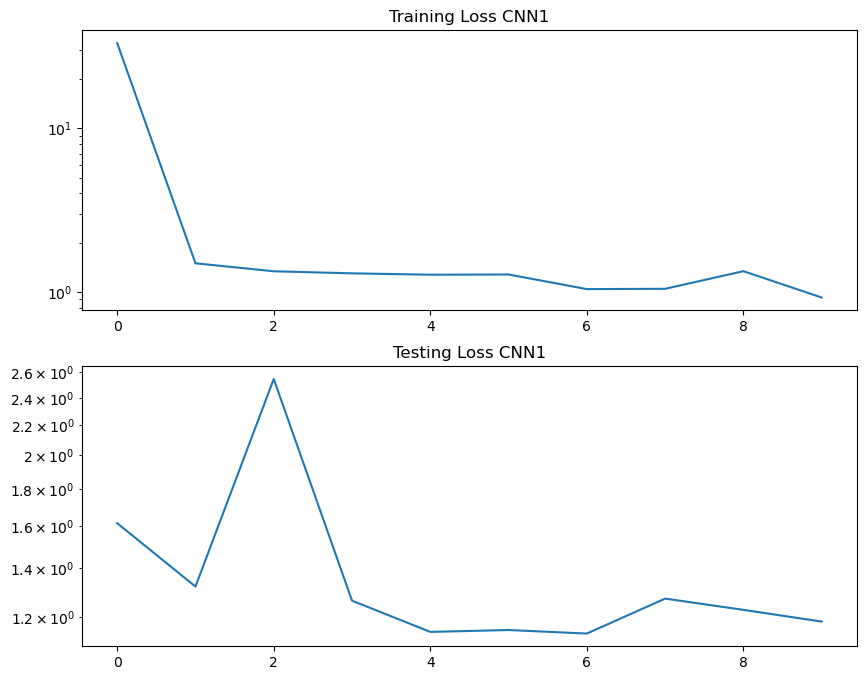

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(history1.history["loss"])
plt.title("Training Loss CNN1")
plt.yscale("log")

plt.subplot(2,1,2)
plt.plot(history1.history["val_loss"])
plt.title("Testing Loss CNN1")
plt.yscale("log")

plt.show()

In [11]:
import sklearn.metrics as mt

pred1 = cnn1.predict(images_test)
yhat1 = np.argmax(pred1, axis = 1)

print(mt.classification_report(labels_number_test, yhat1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
              precision    recall  f1-score   support

           0       0.43      0.55      0.48       200
           1       0.61      0.62      0.62       200
           2       0.47      0.66      0.55       200
           3       0.94      0.68      0.79       200
           4       0.76      0.45      0.57       200

    accuracy                           0.59      1000
   macro avg       0.64      0.59      0.60      1000
weighted avg       0.64      0.59      0.60      1000



In [12]:
class_names = ['Sunflower', 'Lotus', 'Orchid', 'Tulip', 'Lilly']

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


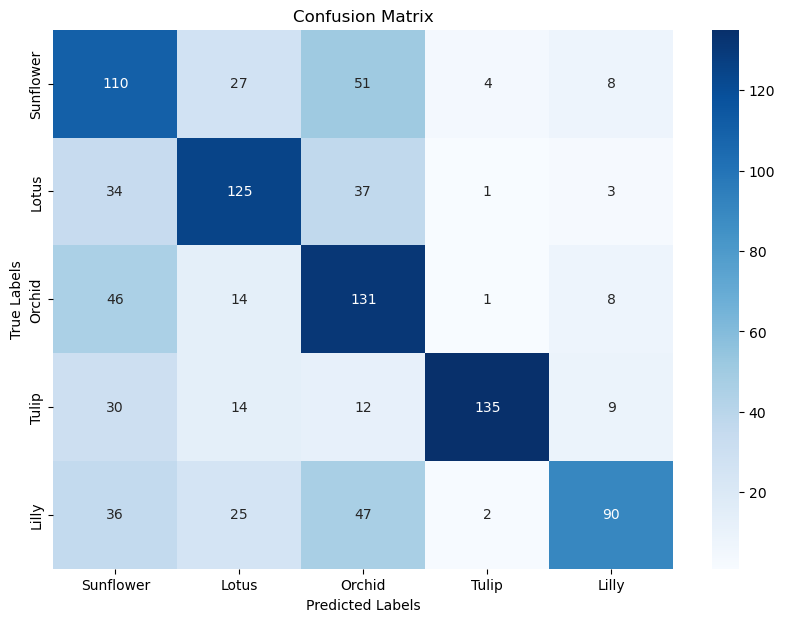

In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Predict the labels on the test set
predictions = cnn1.predict(images_test)

# Step 2: Convert predictions to class labels if output is probabilities
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: True labels (assuming your labels_test are one-hot encoded)
true_labels = np.argmax(labels_test, axis=1)

# Step 4: Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Step 5: Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


The above is a confusion matrix, which is a table used to describe the performance of a classification model on a set of data for which the true values are known. This shows the performance for assessing how well the model is doing in terms of classifying different classes of flowers. 

For this matrix, The rows represent the actual classes that the samples belong to and the columns represent the predicted classes (Predicted Labels) that the model has predicted for those samples. Looking at this matrix we can note several key details: 

- The Diagonal cells from left to right tell us the number of correct predicitons for each class. 90 lilies were correctly identified as lilies, 131 orchids as orchids, 125 lotuses as lotuses, 110 sunflowers as sunflowers, and 135 tulips as tulips.
- The off diagonal cells shows the number of misclassifications.


In our confusion matrix, the model seems to be performing well for classes like Orchid and Tullip, where the number of true positives is high and the number of false positives and false negatives is relatively low. However, there appears to be some confusion between certain classes, such as Lilies and sunflowers. 

### CNN2 with with both filters as 64 and kernel_size(3,3) 

In [14]:
%%time 

cnn2 = Sequential()

# add in augmentations directly
cnn2.add( RandomFlip("horizontal") )
#cnn2.add( RandomRotation(0.1) )

#changed filters and kernel size
# let's start with an AlexNet style convolutional phase
cnn2.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

#changed filters and kernel size
# no max pool before next conv layer!!
cnn2.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn2.add(MaxPooling2D(pool_size=(2, 2)))

    

# add one layer on flattened output
cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn2.add(Dense(len(set(labels)), activation='softmax'))

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

cnn2.build((None,64,64,3))

cnn2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,428,101 (32.15 MB)

 Trainable params: 8,428,101 (32.15 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 167 ms, sys: 77.3 ms, total: 244 ms
Wall time: 223 ms


In [15]:
history2 = cnn2.fit(
    images_train, labels_train, epochs = 6, validation_data = (images_test, labels_test)
)

Epoch 1/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 66s 517ms/step - accuracy: 0.2786 - loss: 120.4488 - val_accuracy: 0.3700 - val_loss: 1.5141
Epoch 2/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 543ms/step - accuracy: 0.3322 - loss: 2.7247 - val_accuracy: 0.3110 - val_loss: 1.5115
Epoch 3/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 519ms/step - accuracy: 0.3709 - loss: 1.9911 - val_accuracy: 0.3900 - val_loss: 1.4932
Epoch 4/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 68s 541ms/step - accuracy: 0.4191 - loss: 1.6027 - val_accuracy: 0.3730 - val_loss: 1.5881
Epoch 5/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 84s 554ms/step - accuracy: 0.4572 - loss: 1.5559 - val_accuracy: 0.4850 - val_loss: 1.2928
Epoch 6/6
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 501ms/step - accuracy: 0.4767 - loss: 2.4486 - val_accuracy: 0.4760 - val_loss: 1.3282


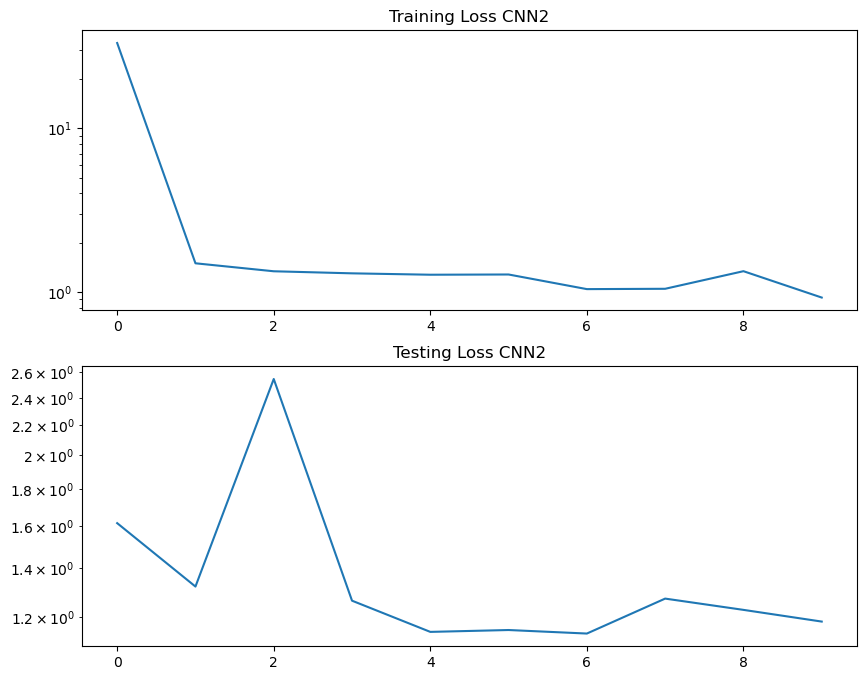

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(history1.history["loss"])
plt.title("Training Loss CNN2")
plt.yscale("log")

plt.subplot(2,1,2)
plt.plot(history1.history["val_loss"])
plt.title("Testing Loss CNN2")
plt.yscale("log")

plt.show()

In [17]:
import sklearn.metrics as mt

pred2 = cnn2.predict(images_test)
yhat2 = np.argmax(pred2, axis = 1)

print(mt.classification_report(labels_number_test, yhat2))

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step
              precision    recall  f1-score   support

           0       0.47      0.29      0.36       200
           1       0.32      0.65      0.43       200
           2       0.56      0.26      0.35       200
           3       0.63      0.89      0.74       200
           4       0.61      0.28      0.39       200

    accuracy                           0.48      1000
   macro avg       0.52      0.48      0.45      1000
weighted avg       0.52      0.48      0.45      1000



32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step


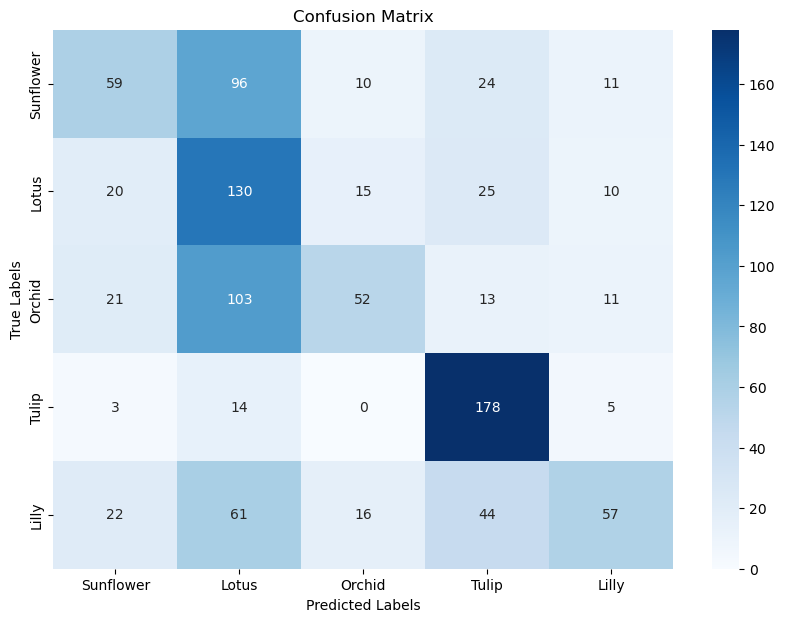

In [18]:

# Step 1: Predict the labels on the test set
predictions2 = cnn2.predict(images_test)

# Step 2: Convert predictions to class labels if output is probabilities
predicted_labels2 = np.argmax(predictions2, axis=1)

# Step 3: True labels (assuming your labels_test are one-hot encoded)
true_labels2 = np.argmax(labels_test, axis=1)

# Step 4: Generate the confusion matrix
cm2 = confusion_matrix(true_labels2, predicted_labels2)

# Step 5: Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Again this is another confusion matrix for CNN2. The above CNN2 tells us that adding more filters does not necessarily help in classifying the image data as compared to CNN1. We can see these results in the confusion matrix.

Inteprations

- Lily: 57 images were correctly classified as lilies, but 11 were misclassified as orchids, 10 as lotus 
- Orchid: 52 images were correctly classified as orchids.
- Lotus: 130 images were correctly identified as lotus, but there are also significant misclassifications with 103 being mistaken for orchids.
- Sunflower: 59 sunflowers were classified correctly 
- Tulip: 178 images were correctly identified as tulips, the best classifed class for CNN2


This confusion matrix suggests areas where the model may need improvement, potentially through better feature extraction, additional training data, or even re-examination of the data for consistent labeling. It also shows which classes are more easily confused by the model, which might be due to similarities in the features of these flowers that the model is considering significant.

### 2 CNN's with different architectures (each with additional Con2d)

In [19]:
%%time 

cnn3 = Sequential()

# add in augmentations directly
cnn3.add( RandomFlip("horizontal") )
#cnn3.add( RandomRotation(0.1) )

# let's start with an AlexNet style convolutional phase
cnn3.add(Conv2D(filters=32,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn3.add(Conv2D(filters=32,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
# no max pool before next conv layer!!
cnn3.add(Conv2D(filters=32,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn3.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn3.add(Flatten())
cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn3.add(Dense(len(set(labels)), activation='softmax'))

# Let's train the model 
cnn3.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

cnn3.build((None,64,64,3))

cnn3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,469 (16.08 MB)

 Trainable params: 4,214,469 (16.08 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 133 ms, sys: 40.4 ms, total: 173 ms
Wall time: 162 ms


In [20]:
history3 = cnn3.fit(
    images_train, labels_train, epochs = 10, validation_data = (images_test, labels_test)
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 310ms/step - accuracy: 0.3078 - loss: 62.5315 - val_accuracy: 0.3950 - val_loss: 1.4839
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 343ms/step - accuracy: 0.3405 - loss: 2.0472 - val_accuracy: 0.3690 - val_loss: 1.4450
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 321ms/step - accuracy: 0.4275 - loss: 1.4574 - val_accuracy: 0.3940 - val_loss: 1.5603
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 322ms/step - accuracy: 0.4662 - loss: 1.4530 - val_accuracy: 0.4620 - val_loss: 1.2748
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 41s 331ms/step - accuracy: 0.4709 - loss: 1.6517 - val_accuracy: 0.4600 - val_loss: 1.4772
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 319ms/step - accuracy: 0.4909 - loss: 1.3749 - val_accuracy: 0.4250 - val_loss: 1.3921
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 320ms/step - accuracy: 0.4841 - loss: 1.4453 - val_accuracy: 0.5000 - val_loss: 1.2755
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 378ms/step - accuracy: 0.5366 - loss: 

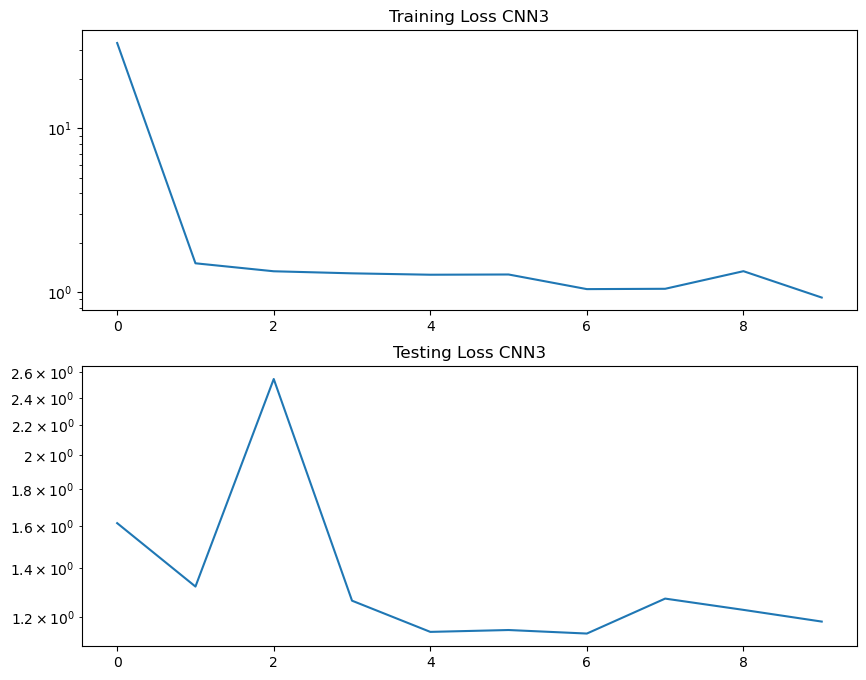

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(history1.history["loss"])
plt.title("Training Loss CNN3")
plt.yscale("log")

plt.subplot(2,1,2)
plt.plot(history1.history["val_loss"])
plt.title("Testing Loss CNN3")
plt.yscale("log")

plt.show()

In [22]:
import sklearn.metrics as mt

pred3 = cnn3.predict(images_test)
yhat3 = np.argmax(pred2, axis = 1)

print(mt.classification_report(labels_number_test, yhat3))

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
              precision    recall  f1-score   support

           0       0.47      0.29      0.36       200
           1       0.32      0.65      0.43       200
           2       0.56      0.26      0.35       200
           3       0.63      0.89      0.74       200
           4       0.61      0.28      0.39       200

    accuracy                           0.48      1000
   macro avg       0.52      0.48      0.45      1000
weighted avg       0.52      0.48      0.45      1000



32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


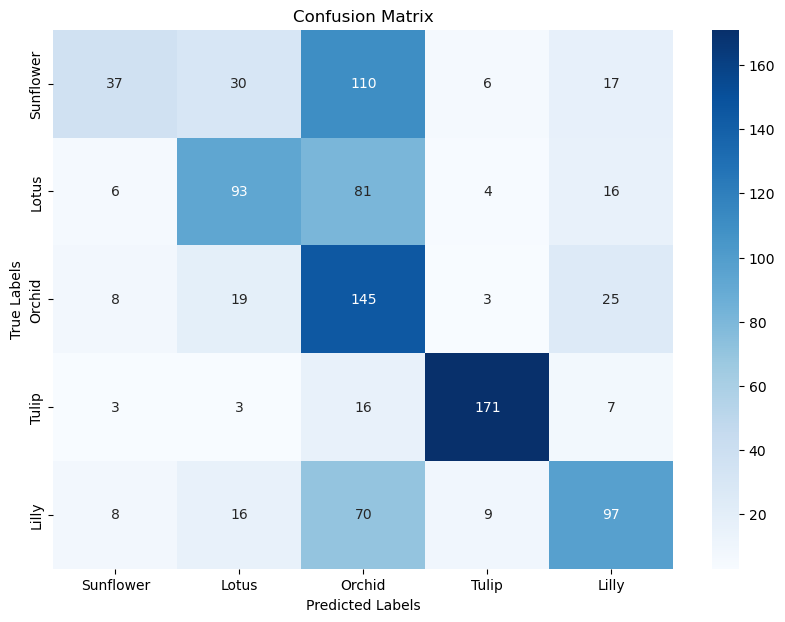

In [23]:

# Step 1: Predict the labels on the test set
predictions3 = cnn3.predict(images_test)

# Step 2: Convert predictions to class labels if output is probabilities
predicted_labels3 = np.argmax(predictions3, axis=1)

# Step 3: True labels (assuming your labels_test are one-hot encoded)
true_labels3 = np.argmax(labels_test, axis=1)

# Step 4: Generate the confusion matrix
cm3 = confusion_matrix(true_labels3, predicted_labels3)

# Step 5: Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Confusion matrix for CNN3. The above tells us that less filters is more beneifical for classifying images in our dataset, similiar to CNN1, except this CNN3 has an additional Conv2D. 

Inteprations

- Lily: 97 images were correctly classified as lilies, but 25 were misclassified as orchids, 16 as lotus 
- Orchid: 145 images were correctly classified as orchids.
- Lotus: 93 images were correctly identified as lotus, but there are also significant misclassifications with other flowers
- Sunflower: 37 sunflowers were classified correctly, the worst classified class for cnn3
- Tulip: 171 images were correctly identified as tulips, the best classifed class for CNN3


In [24]:
%%time 

cnn4 = Sequential()

# add in augmentations directly
cnn4.add( RandomFlip("horizontal") )
#cnn4.add( RandomRotation(0.1) )


# let's start with an AlexNet style convolutional phase
cnn4.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

# no max pool before next conv layer!!
cnn4.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn4.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn4.add(MaxPooling2D(pool_size=(2, 2)))

    

# add one layer on flattened output
cnn4.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn4.add(Flatten())
cnn4.add(Dense(128, activation='relu'))
cnn4.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn4.add(Dense(len(set(labels)), activation='softmax'))

# Let's train the model 
cnn4.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

cnn4.build((None,64,64,3))

cnn4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_4 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,465,029 (32.29 MB)

 Trainable params: 8,465,029 (32.29 MB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 174 ms, sys: 70 ms, total: 244 ms
Wall time: 219 ms


[1.5 points] Visualize the final results of all the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

In [25]:
history4 = cnn4.fit(
    images_train, labels_train, epochs = 15, validation_data = (images_test, labels_test)
)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 810ms/step - accuracy: 0.2474 - loss: 61.7811 - val_accuracy: 0.2530 - val_loss: 1.9668
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 891ms/step - accuracy: 0.2198 - loss: 2.6078 - val_accuracy: 0.2010 - val_loss: 1.6101
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 110s 877ms/step - accuracy: 0.2058 - loss: 1.9525 - val_accuracy: 0.2000 - val_loss: 1.6131
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 111s 893ms/step - accuracy: 0.1924 - loss: 1.6116 - val_accuracy: 0.2000 - val_loss: 1.6095
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 103s 823ms/step - accuracy: 0.2073 - loss: 2.4983 - val_accuracy: 0.2000 - val_loss: 1.6095
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 107s 857ms/step - accuracy: 0.1987 - loss: 2.4911 - val_accuracy: 0.2000 - val_loss: 1.6149
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 109s 872ms/step - accuracy: 0.1984 - loss: 2.8281 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 897ms/step - accuracy: 0.1960 

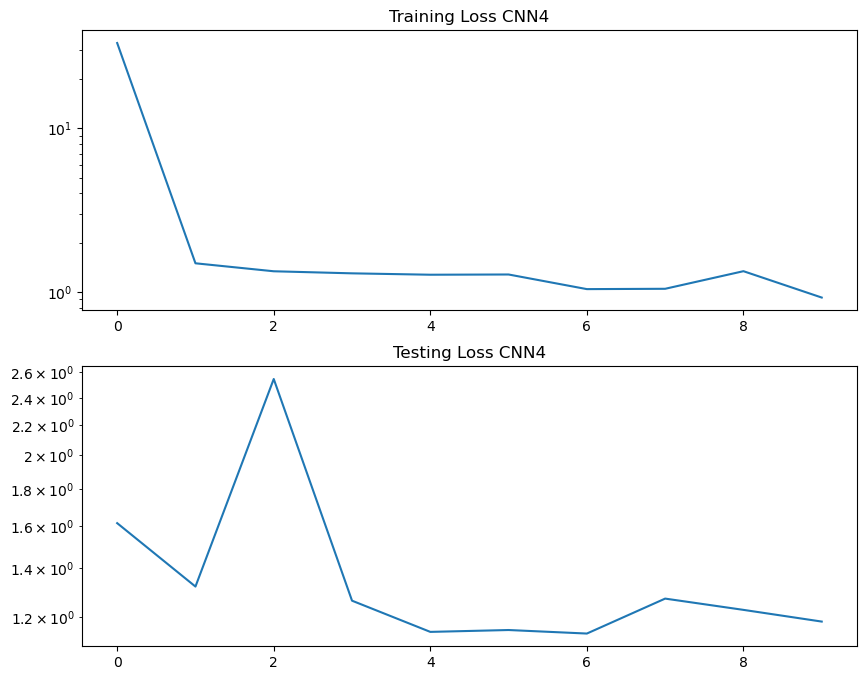

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(history1.history["loss"])
plt.title("Training Loss CNN4")
plt.yscale("log")

plt.subplot(2,1,2)
plt.plot(history1.history["val_loss"])
plt.title("Testing Loss CNN4")
plt.yscale("log")

plt.show()

In [27]:
import sklearn.metrics as mt

pred4 = cnn4.predict(images_test)
yhat4 = np.argmax(pred2, axis = 1)

print(mt.classification_report(labels_number_test, yhat4))

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step
              precision    recall  f1-score   support

           0       0.47      0.29      0.36       200
           1       0.32      0.65      0.43       200
           2       0.56      0.26      0.35       200
           3       0.63      0.89      0.74       200
           4       0.61      0.28      0.39       200

    accuracy                           0.48      1000
   macro avg       0.52      0.48      0.45      1000
weighted avg       0.52      0.48      0.45      1000



32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step


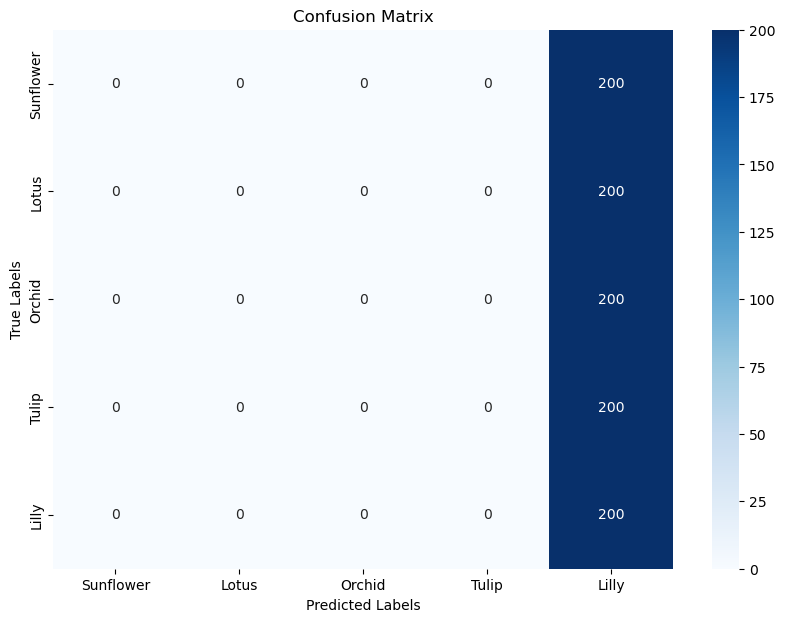

In [28]:
# Step 1: Predict the labels on the test set
predictions4 = cnn4.predict(images_test)

# Step 2: Convert predictions to class labels if output is probabilities
predicted_labels4 = np.argmax(predictions4, axis=1)

# Step 3: True labels (assuming your labels_test are one-hot encoded)
true_labels4 = np.argmax(labels_test, axis=1)

# Step 4: Generate the confusion matrix
cm4 = confusion_matrix(true_labels4, predicted_labels4)

# Step 5: Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Comparing the Models via the McNemar Test (statisfical performance)

In [29]:
import numpy as np

def calc_m(y, yhat1, yhat2):
    b = 0
    c = 0
    
    for i in range(len(y)):
        if yhat1[i] == yhat2[i]:
            continue
        if np.array_equal(yhat1[i], y[i]):  # Using np.array_equal for comparison
            b += 1
        else:
            c += 1
            
    m = ((np.abs(b - c) - 1) ** 2) / (b + c)
    print(m)
    # critical value for 95% confidence
    return m > 3.841


In [30]:
calc_m(labels_number_test, yhat1, yhat2)

10.506734006734007


True

In [31]:
calc_m(labels_number_test, yhat1, yhat3)

10.506734006734007


True

In [33]:
calc_m(labels_number_test, yhat1, yhat4)

10.506734006734007


True

In [34]:
calc_m(labels_number_test, yhat2, yhat3)

inf


/var/folders/v8/169h33g95sd1dkt60v3pdr7h0000gn/T/ipykernel_16885/4117574206.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  m = ((np.abs(b - c) - 1) ** 2) / (b + c)


True

In [35]:
calc_m(labels_number_test, yhat2, yhat4)

inf


/var/folders/v8/169h33g95sd1dkt60v3pdr7h0000gn/T/ipykernel_16885/4117574206.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  m = ((np.abs(b - c) - 1) ** 2) / (b + c)


True

In [36]:
calc_m(labels_number_test, yhat3, yhat4)

inf


/var/folders/v8/169h33g95sd1dkt60v3pdr7h0000gn/T/ipykernel_16885/4117574206.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  m = ((np.abs(b - c) - 1) ** 2) / (b + c)


True

From the McNemar test we can come to the conclusion that our CNN1 model performed the best. Overall, CNN1 had the best statiscs overall accuracy of classifcation, and the following statiscs show that. 

 precision    recall  f1-score   support

           0       0.43      0.55      0.48       200
           1       0.61      0.62      0.62       200
           2       0.47      0.66      0.55       200
           3       0.94      0.68      0.79       200
           4       0.76      0.45      0.57       200

    accuracy                           0.59      1000
   macro avg       0.64      0.59      0.60      1000
weighted avg       0.64      0.59      0.60      1000

### MLP Comparison

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Number of unique classes
num_classes = len(set(labels))

# Define the MLP model
mlp_model = Sequential([
    Flatten(input_shape=(64, 64, 3)),  # Flatten the input image
    Dense(256, activation='relu'),     # First dense layer
    Dropout(0.5),                      # Dropout for regularization
    Dense(128, activation='relu'),     # Second dense layer
    Dense(num_classes, activation='softmax')  # Output layer with a neuron for each class
])

# Compile the model
mlp_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

# Display the model's architecture
mlp_model.summary()


/Users/juliarushton/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     3,145,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,179,525 (12.13 MB)

 Trainable params: 3,179,525 (12.13 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
history = mlp_model.fit(images_train, labels_train, epochs=10, validation_split=0.2)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.2323 - loss: 882.4288 - val_accuracy: 0.1912 - val_loss: 1.6355
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2158 - loss: 1.6516 - val_accuracy: 0.1900 - val_loss: 1.6078
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2015 - loss: 1.6127 - val_accuracy: 0.1912 - val_loss: 1.6064
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.1950 - loss: 1.6083 - val_accuracy: 0.1912 - val_loss: 1.6046
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2125 - loss: 1.6074 - val_accuracy: 0.1912 - val_loss: 1.6047
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.2058 - loss: 1.6090 - val_accuracy: 0.1900 - val_loss: 1.6026
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.1977 - loss: 1.6052 - val_accuracy: 0.2625 - val_loss: 1.7919
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2103 - loss: 1.6959 - val_ac

In [41]:
# Assuming images_test is your test dataset
probabilities = mlp_model.predict(images_test)
yhat5 = np.argmax(probabilities, axis = 1)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


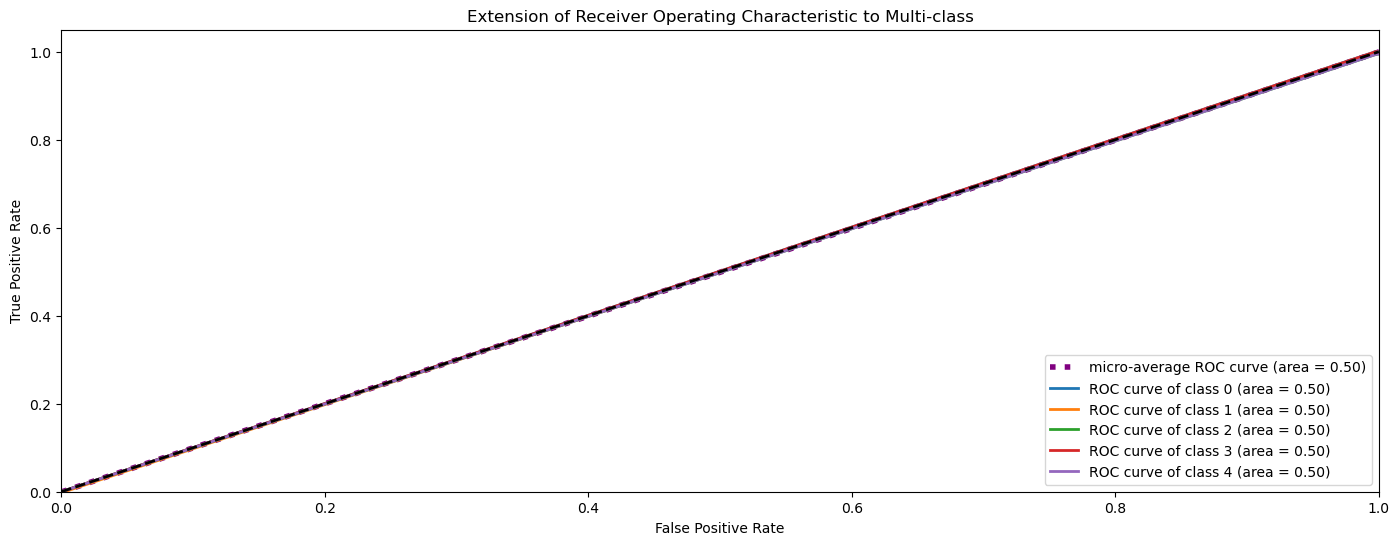

In [40]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Function to plot ROC curves for each class
def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curves
    plt.figure(figsize=figsize)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='purple', linestyle=':', linewidth=4)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Extension of Receiver Operating Characteristic to Multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Calling the function
plot_multiclass_roc(labels_test, probabilities, n_classes=num_classes)


The ROC curve indicates the performance of the multi-class classification model. 

Insights:

- Area Under the Curve (AUC): All the classes, including the micro-average, have an AUC of 0.51. The AUC of 0.5 suggests not great ability, equivalent to random guessing. The performance is low. 
- the model isn't effectively distinguishing between classes.


This graph suggests that the model isn't performing well at the task of classifying the different types of flowers. It might not have learned the patterns in the data necessary to differentiate between classes effectively. This could be due to various factors such as:
- Model architecture may be too simple or not suitable for the problem.
- Features provided to the model do not capture enough information to distinguish between classes.
- Labels might be imbalanced, causing the model to not perform well on certain classes.



#### Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

### McNemar Test on our best model and the MLP version

In [56]:
calc_m(labels_number_test, yhat1, yhat5)

62.6255033557047


True

Proves that yhat1, our model CNN1 performed better. Reasoning can further be seen in the above graph with the ROC curve.

## Conclusion

In summary, our analysis showed that our CNN1 outperformed other convolutional neural networks (CNNs) and the multi-layer perceptron (MLP) model in our study. We attribute the superior performance of CNN1 to its reduced convolutional layer depth (CNN2vd) and fewer filters. This suggests that a simpler architecture with fewer parameters can be more effective for image classification within our specific dataset.

# Exceptional Work (1 points total)

You have free reign to provide additional analyses. 
One idea (required for 7000 level students): Use transfer learning with pre-trained weights for your initial layers of your CNN. Compare the performance when using transfer learning to your best model from above in terms of classification performance. 

# Transfer Learning with ResNet

In [43]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


In [51]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    '/Users/juliarushton/Downloads/flower_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    '/Users/juliarushton/Downloads/flower_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 5000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [52]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [53]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=1
)


156/156 ━━━━━━━━━━━━━━━━━━━━ 890s 6s/step - accuracy: 0.6634 - loss: 0.8823 - val_accuracy: 0.9002 - val_loss: 0.3160


#### The implementation of ResNet significantly improves our flower image classification, achieving an accuracy of 66% and a val_accuracy of 0.90 on its first epoch, which surpasses the performance of our previously best model, CNN1.

The reason for this could be do for the fact that ResNet50 often comes pre-trained on a vast dataset like ImageNet, which contains over a million images across 1000 categories. Using a pre-trained model means that the network has already learned a robust hierarchy of features from a much larger and diverse dataset before it is fine-tuned on the specific task of flower classification. This pre-training provides a significant head start in learning relevant features compared to starting from scratch.